The data is loaded from the CSV file and the target variable converted to one-hot encodings.

In [1]:
import pandas as pd
columns = ["pixel"+str(i) for i in range(10000)]
df = pd.read_csv("mapping.csv", names=["class"]+columns, dtype={'class':str, 'img':str})
df.head()

,class,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel9990,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999
0,alone,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
1,alone,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
2,alone,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
3,alone,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
4,alone,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109


In [2]:
df.shape

(169, 10001)

In [3]:
from sklearn import preprocessing
import numpy as np
from keras.utils import np_utils

n = df.shape[0]
nb_classes = df["class"].nunique()

le = preprocessing.LabelEncoder()
classes = df["class"]
le.fit(classes)
df["class"] = le.transform(classes)

X = df.iloc[:, 1:] # everything but the class

y = df["class"]
y = np_utils.to_categorical(y, nb_classes) #one hot encodings

Using TensorFlow backend.


The pixel data is reshaped because the ImageDataGenerator takes a 3D representation of a image - (width, height, channel). Grayscale images have one channel but color images contain RGB data. Then the data is split into training and testing sets.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

n = X.shape[0]
X = np.array(X).reshape(n, 100, 100, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135, 100, 100, 1), (34, 100, 100, 1), (135, 3), (34, 3))

We create an `ImageDataGenerator` object that will supplement our training data and help the model generalize better. The train and test data generators will also normalize the data.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
#         rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow(X_train, y_train)
test_generator = test_datagen.flow(X_test, y_test)

A sample of the images generated by the train generator and the some of the original images are displayed below.

In [7]:
import matplotlib.pyplot as plt

p = train_generator.next()
rows = 2
cols = 4

fig=plt.figure(figsize=(cols*4, rows*4))
for i in range(1, 9):
    img = np.squeeze(p[0][i-1])
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
plt.show()

<Figure size 1600x800 with 8 Axes>

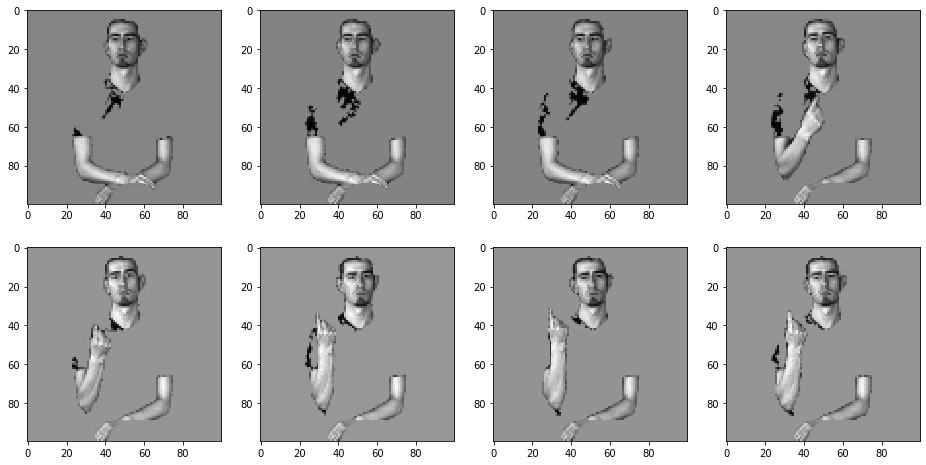

In [8]:
fig=plt.figure(figsize=(16, 8))
cols = 4
rows = 2

for i in range(1, cols*rows+1):
    img = np.squeeze(X[i-1])
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
plt.show()

We then define a function to build a convolutional neural network with 3 convolutions using 3x3 kernels, ReLU activation and max-pooling. Finally, logistic regression is used to predict the output of the model. A dropout layer is added to further generalize the model and prevent it from overfitting.

In [12]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
from keras import optimizers

input_shape=(100, 100, 1)

def create_model(lr=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    opt = optimizers.Adam(lr=lr)
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

We arbitrarily choose the initial batch size and epochs to establish a baseline.

In [10]:
batch_size=32
epochs=20

Fit the unaugumented train data first to make sure everything is running correctly, then train the model using generated data.

In [13]:
model = create_model()
history = model.fit(X_train/255, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
135/135 [==============================] - 2s 11ms/step - loss: 1.0941 - acc: 0.4444
Epoch 2/20
135/135 [==============================] - 1s 9ms/step - loss: 1.0364 - acc: 0.5111
Epoch 3/20
135/135 [==============================] - 1s 10ms/step - loss: 1.0014 - acc: 0.5111
Epoch 4/20
135/135 [==============================] - 1s 9ms/step - loss: 0.9972 - acc: 0.5111
Epoch 5/20
135/135 [==============================] - 1s 8ms/step - loss: 0.9362 - acc: 0.5111
Epoch 6/20
135/135 [==============================] - 1s 9ms/step - loss: 0.8794 - acc: 0.5333
Epoch 7/20
135/135 [==============================] - 2s 13ms/step - loss: 0.7800 - acc: 0.6741
Epoch 8/20
135/135 [==============================] - 2s 11ms/step - loss: 0.7408 - acc: 0.6815
Epoch 9/20
135/135 [==============================] - 1s 10ms/step - loss: 0.6322 - acc: 0.7259
Epoch 10/20
135/135 [==============================] - 1s 11ms/step - loss: 0.5186 - acc: 0.8148
Epoch 11/20
135/135 [======================

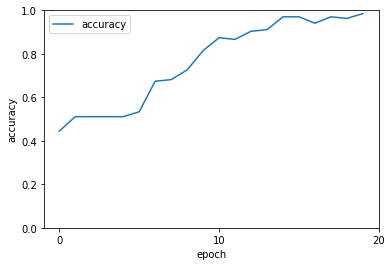

In [14]:
import matplotlib.pyplot as plt

plt.ylim(0, 1)
plt.plot(history.history["acc"], label="accuracy")
plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 20+1, 10));

In [15]:
model = create_model()
history = model.fit(X_train/255, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test/255, y_test))

Train on 135 samples, validate on 34 samples
Epoch 1/20
135/135 [==============================] - 2s 12ms/step - loss: 1.0861 - acc: 0.4889 - val_loss: 1.0591 - val_acc: 0.4412
Epoch 2/20
135/135 [==============================] - 1s 10ms/step - loss: 1.0189 - acc: 0.5111 - val_loss: 1.1186 - val_acc: 0.4412
Epoch 3/20
135/135 [==============================] - 1s 9ms/step - loss: 1.0061 - acc: 0.5111 - val_loss: 1.0750 - val_acc: 0.4412
Epoch 4/20
135/135 [==============================] - 1s 9ms/step - loss: 0.9898 - acc: 0.5111 - val_loss: 1.0264 - val_acc: 0.4412
Epoch 5/20
135/135 [==============================] - 1s 9ms/step - loss: 0.9235 - acc: 0.5259 - val_loss: 1.1090 - val_acc: 0.4412
Epoch 6/20
135/135 [==============================] - 1s 10ms/step - loss: 0.9309 - acc: 0.5407 - val_loss: 0.9542 - val_acc: 0.4412
Epoch 7/20
135/135 [==============================] - 1s 9ms/step - loss: 0.8160 - acc: 0.6370 - val_loss: 0.9158 - val_acc: 0.5294
Epoch 8/20
135/135 [========

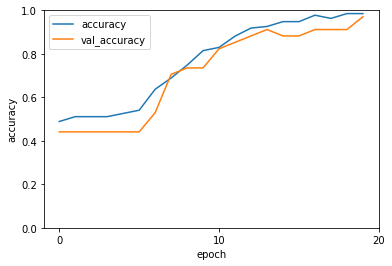

In [16]:
import matplotlib.pyplot as plt

plt.ylim(0, 1)
plt.plot(history.history["acc"], label="accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 20+1, 10));

In [17]:
model = create_model()
history = model.fit_generator(train_generator,
        steps_per_epoch=5, #2000 // batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=2) #800 // batch_size)
model.save_weights('cnn3.h5')

Epoch 1/20
5/5 [==============================] - 3s 507ms/step - loss: 10.3850 - acc: 0.3028 - val_loss: 1.2642 - val_acc: 0.4412
Epoch 2/20
5/5 [==============================] - 1s 297ms/step - loss: 7.0103 - acc: 0.5633 - val_loss: 1.8952 - val_acc: 0.4412
Epoch 3/20
5/5 [==============================] - 1s 251ms/step - loss: 7.9611 - acc: 0.5061 - val_loss: 2.4759 - val_acc: 0.4412
Epoch 4/20
5/5 [==============================] - 1s 252ms/step - loss: 6.9460 - acc: 0.5691 - val_loss: 2.8892 - val_acc: 0.4412
Epoch 5/20
5/5 [==============================] - 1s 281ms/step - loss: 7.6495 - acc: 0.5254 - val_loss: 3.1673 - val_acc: 0.4412
Epoch 6/20
5/5 [==============================] - 1s 266ms/step - loss: 8.3647 - acc: 0.4810 - val_loss: 3.3513 - val_acc: 0.4412
Epoch 7/20
5/5 [==============================] - 1s 247ms/step - loss: 7.8455 - acc: 0.5132 - val_loss: 3.4712 - val_acc: 0.4412
Epoch 8/20
5/5 [==============================] - 1s 252ms/step - loss: 7.9493 - acc: 0.5

Print test and validation accuracies:

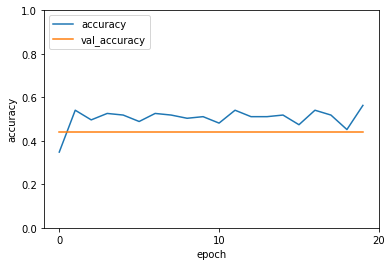

In [18]:
import matplotlib.pyplot as plt

plt.ylim(0, 1)
plt.plot(history.history["acc"], label="accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 20+1, 10));

# Tuning

In [19]:
from keras import optimizers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
epochs = [i*10 for i in range(6)]
batch_size = [10, 20, 40, 60, 80]
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.20)

grid_values = {'epochs': epochs, "lr": learn_rate}
model = KerasClassifier(build_fn=create_model)
grid_acc = GridSearchCV(model, param_grid = grid_values,scoring = 'accuracy', cv=3)
grid_result = grid_acc.fit(X_train, y_train)

Epoch 1/10
90/90 [==============================] - 2s 24ms/step - loss: 9.3412 - acc: 0.3000
Epoch 2/10
90/90 [==============================] - 1s 11ms/step - loss: 9.7070 - acc: 0.3444
Epoch 3/10
90/90 [==============================] - 1s 10ms/step - loss: 9.0639 - acc: 0.4222
Epoch 4/10
90/90 [==============================] - 1s 12ms/step - loss: 8.9545 - acc: 0.4444
Epoch 5/10
90/90 [==============================] - 1s 10ms/step - loss: 8.9545 - acc: 0.4444
Epoch 6/10
90/90 [==============================] - 1s 8ms/step - loss: 8.9545 - acc: 0.4444
Epoch 7/10
90/90 [==============================] - 1s 14ms/step - loss: 8.9545 - acc: 0.4444
Epoch 8/10
90/90 [==============================] - 1s 12ms/step - loss: 8.9545 - acc: 0.4444
Epoch 9/10
90/90 [==============================] - 1s 13ms/step - loss: 8.9545 - acc: 0.4444
Epoch 10/10
90/90 [==============================] - 1s 12ms/step - loss: 8.9545 - acc: 0.4444
Epoch 1/10
90/90 [==============================] - 2s 26ms/

KeyboardInterrupt: 

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Retrain

Retrain model using paramters lr=0.001 and epochs=30 found using GridSearchCV.

In [20]:
model = create_model(lr=0.001)
history = model.fit_generator(train_generator,
        steps_per_epoch=5, #2000 // batch_size,
        epochs=30,
        validation_data=test_generator,
        validation_steps=2) #800 // batch_size)
model.save_weights('first_try.h5')

Epoch 1/30
5/5 [==============================] - 3s 605ms/step - loss: 8.4003 - acc: 0.4288 - val_loss: 1.2252 - val_acc: 0.4706
Epoch 2/30
5/5 [==============================] - 1s 260ms/step - loss: 7.8455 - acc: 0.5132 - val_loss: 1.8603 - val_acc: 0.4118
Epoch 3/30
5/5 [==============================] - 1s 272ms/step - loss: 7.5574 - acc: 0.5311 - val_loss: 2.1003 - val_acc: 0.4412
Epoch 4/30
5/5 [==============================] - 1s 256ms/step - loss: 7.6612 - acc: 0.5247 - val_loss: 2.6023 - val_acc: 0.4118
Epoch 5/30
5/5 [==============================] - 1s 258ms/step - loss: 7.1420 - acc: 0.5569 - val_loss: 2.5174 - val_acc: 0.4706
Epoch 6/30
5/5 [==============================] - 2s 330ms/step - loss: 7.5574 - acc: 0.5311 - val_loss: 2.9095 - val_acc: 0.4118
Epoch 7/30
5/5 [==============================] - 1s 258ms/step - loss: 7.8455 - acc: 0.5132 - val_loss: 2.8637 - val_acc: 0.4412
Epoch 8/30
5/5 [==============================] - 1s 252ms/step - loss: 7.9611 - acc: 0.50

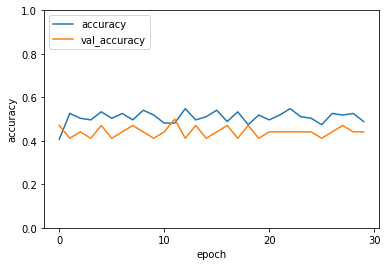

In [21]:
import matplotlib.pyplot as plt

plt.ylim(0, 1)
plt.plot(history.history["acc"], label="accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 30+1, 10));